# Loss functions

**Key message:** loss functions need to be tailored for your application.

In the analogy, optimization is a ball rolling down the hill. This notebook focuses on "what hill is the ball rolling down?"

As in the videos, "loss functions" measure how wrong your model is.

*Required information for optimization: how can the model improve?*

## Setup

To examine that, let's look at an example with a fictional CSV that examines weight and max running speed for cats and dogs:

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

Index(['species', 'weight', 'max_speed'], dtype='object')


<AxesSubplot:xlabel='weight', ylabel='max_speed'>

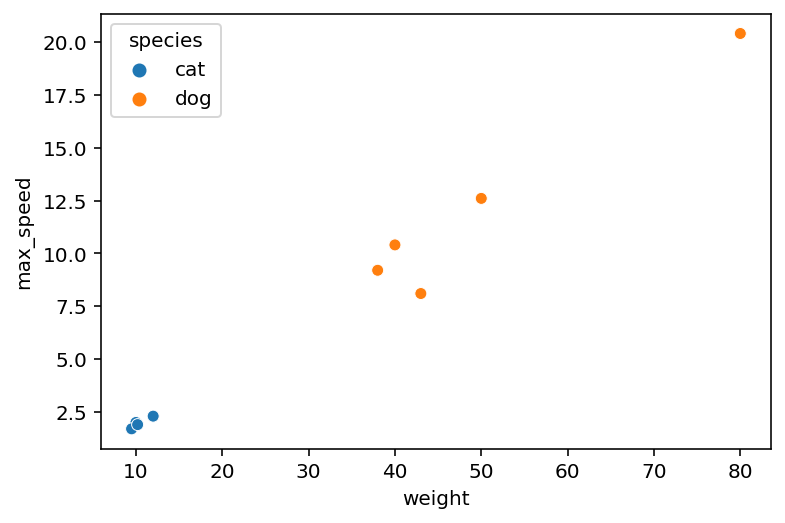

In [2]:
df = pd.read_csv("data0.csv")
print(df.columns)

sns.scatterplot(x="weight", y="max_speed", hue="species", data=df)

## Regression

Clearly, there's a pretty linear relationship between `weight` and `max_running_speed`.

That can be formalized by predicting `max_running_speed` $y$ from `weight` $x$ so $
\widehat{y} = a\cdot x + b$ for some $a$ and $b$.

It's our job to find $a$ and $b$. To do that, let's use linear regression. That will minimize this function:

$$
L(a, b) = \sum_{i=1}^9 (y_i - \widehat{y}_i(a, b))^2
$$

This says the model's cost is gets worse if it predicts a value *too high* or *too low,* and being "too close" is a lot better than being "too far."

(0.0, 9.44981257809246)

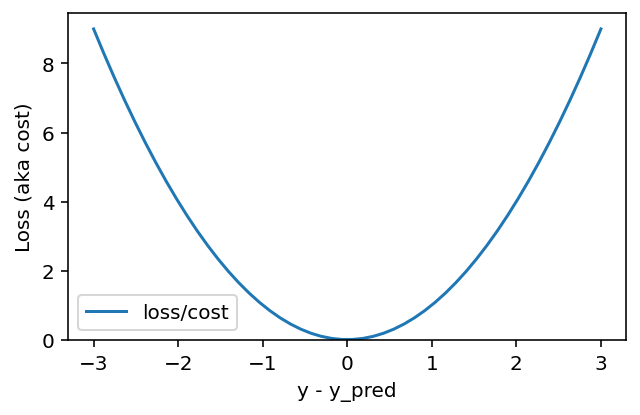

In [3]:
diff = np.linspace(-3, 3)
ax = pd.DataFrame({"y - y_pred": diff, "loss/cost": diff**2}).plot(x="y - y_pred", y="loss/cost", figsize=(5, 3))
ax.set_ylabel("Loss (aka cost)")
ax.set_ylim(0, None)


That is, a loss or cost is incurred if the prediction is not exactly right.

The optimization can be rewritten as the following after pluggin in values for $\widehat{y}$:

$$
L(a, b) = \sum_{i=1}^9 (y_i - (a\cdot x + b))^2
$$

Formally, I write the minimization as

$$
\widehat{a},~\widehat{b} = \arg\min_{a, b} L(a, b)
$$

This sends "find the arguments that minimize $L(a, b)$. To do that, let's write this code:

In [4]:
from sklearn.linear_model import LinearRegression

estimator = LinearRegression()

X = df[["weight"]].to_numpy()
y = df["max_speed"].to_numpy().flatten()
estimator.fit(X, y);

estimator.coef_, estimator.intercept_

(array([0.26061042]), -0.8534077039599737)

So $s \approx 0.26 w - 0.85$ according to our model. Let's see how that performs:

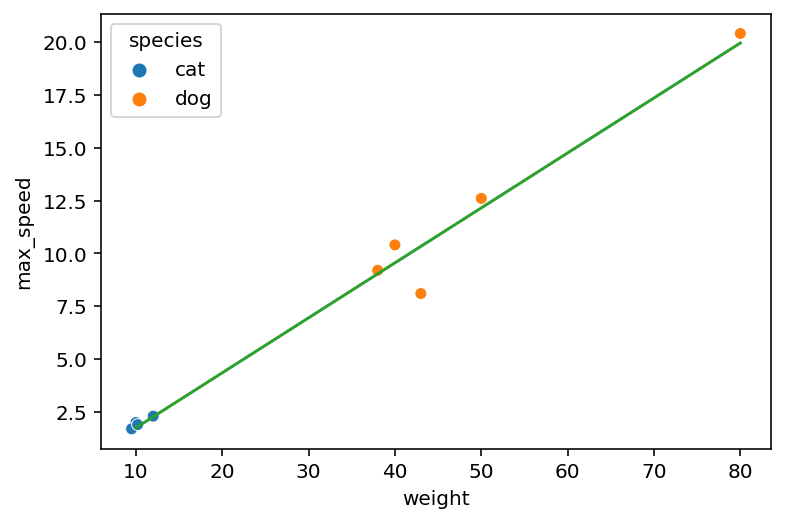

In [5]:
import numpy as np
ax = sns.scatterplot(x="weight", y="max_speed", hue="species", data=df)

x = np.linspace(10, 80)
y = 0.26 * x - 0.85
ax.plot(x, y, "C2", label="prediction")

Great! That worked. As expected, we found a linear relationship between `weight` and `max_speed`.

In [6]:
from IPython.display import Image
Image(url="https://alykhantejani.github.io/images/gradient_descent_line_graph.gif",
      width=600)

But what if we have a different application?

## Classification

Now, let's try to predict if the animal species from `weight` $w$ and `max_speed` $s$. If the species label $y$ is 1 for "dog" and "-1" for cat, let's say that $y = f(s, w)$ for some function $f$.

Specifically, the function $f$ will be a linear model so $\widehat{y} = f(s, w) = a\cdot s + b\cdot w + c$ for a new $a$, $b$ and $c$.

Then, to predict, let's set the predicted species label to be $\text{sign}(\widehat{y})$.

Let's perform this minimization:

$$
\widehat{a},~\widehat{b} = \arg\min_{a, b} \sum_{i=1}^9 (y_i - \widehat{y}_i)^2
$$

In [7]:
from sklearn.linear_model import LinearRegression

est = LinearRegression()

X = df[["weight", "max_speed"]].to_numpy()
y = df["species"].apply(lambda x: -1 if x == "cat" else 1).to_numpy().flatten()

est.fit(X, y);

est.coef_, est.intercept_

(array([ 0.07499803, -0.14382314]), -1.231739616323694)

(0.0, 34.97765380035959)

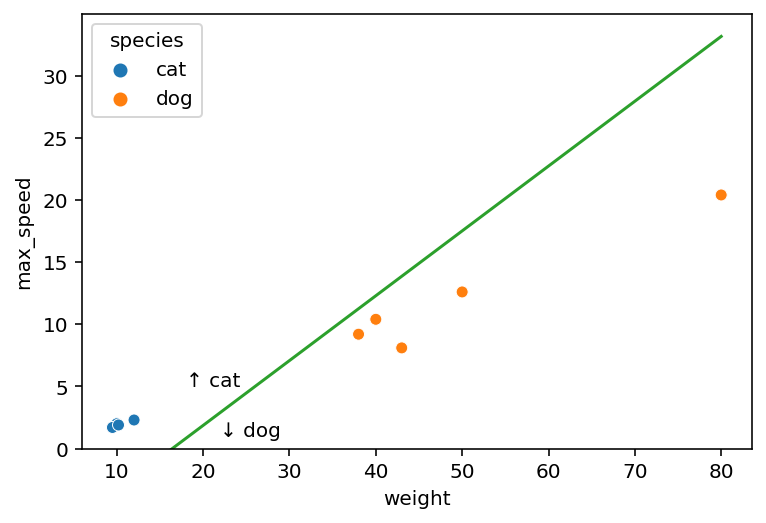

In [8]:
ax = sns.scatterplot(x="weight", y="max_speed", hue="species", data=df)

x = np.linspace(10, 80)
y = np.linspace(2.5, 20)

w = est.coef_[0]*x + est.coef_[1]*y + est.intercept_
dividing_line = (-est.coef_[0]*x - est.intercept_) / est.coef_[1]
ax.plot(x, dividing_line, "C2", label="prediction")
ax.text(18, 5, "↑ cat")
ax.text(22, 1, "↓ dog")
ax.set_ylim(0, None)

Yes, it worked... but it doesn't look good.

### What caused that performance?

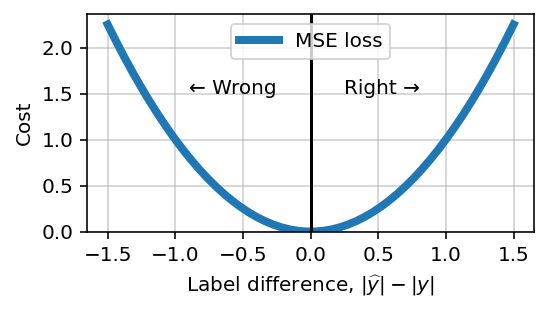

In [9]:
import numpy as np
import matplotlib.pyplot as plt

off = np.linspace(-1.5, 1.5)
cost = (off)**2

fig, ax = plt.subplots(figsize=(4, 2))
ax.plot(off, cost, linewidth=4, label="MSE loss")
ax.set_ylabel("Cost")
ax.set_xlabel(r"Label difference, $|\widehat{y}| - |y|$")
ax.set_ylim(0, None)
ax.grid(alpha=0.6)
ax.text(0.25, 1.5, "Right →")
ax.text(-0.90, 1.5, "← Wrong")
ax.plot([0, 0], [0, 2.5], color="black")
ax.legend(loc="best")

This is especially relevant because we're predicting $\text{sign}(\widehat{y})$. If the prediction $\widehat{y}$ is too large – it's still correct!

Instead, why not only have error when you're wrong? That'd be something like this graph:

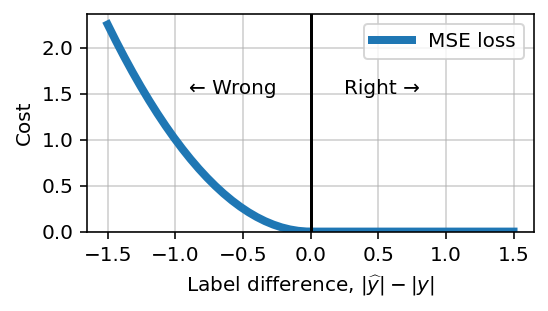

In [10]:
off = np.linspace(-1.5, 1.5)
cost = (off)**2
cost[off > 0] = 0

fig, ax = plt.subplots(figsize=(4, 2))
ax.plot(off, cost, linewidth=4, label="MSE loss")
ax.set_ylabel("Cost")
ax.set_xlabel(r"Label difference, $|\widehat{y}| - |y|$")
ax.set_ylim(0, None)
ax.grid(alpha=0.6)
ax.text(0.25, 1.5, "Right →")
ax.text(-0.90, 1.5, "← Wrong")
ax.plot([0, 0], [0, 2.5], color="black")
ax.legend(loc="best")

This is a lot better – if we're "too correct" (maybe for an easy example) we're not penalized.

There's some theory that says we should minimize this loss function:

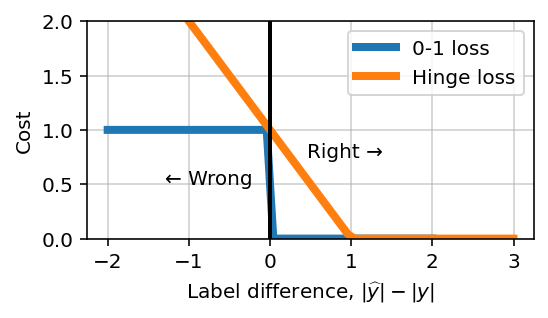

In [11]:
off = np.linspace(-2, 2)
cost = (off < 0)
hinge = np.minimum(off, 0) * -1

fig, ax = plt.subplots(figsize=(4, 2))
ax.plot(off, cost, linewidth=4, label="0-1 loss")
ax.plot(off + 1, hinge, linewidth=4, label="Hinge loss")


ax.set_ylabel("Cost")
ax.set_xlabel(r"Label difference, $|\widehat{y}| - |y|$")
ax.set_ylim(0, 2.0)
ax.grid(alpha=0.6)
ax.text(0.45, 0.75, "Right →")
ax.text(-1.30, 0.5, "← Wrong")
ax.plot([0, 0], [0, 2.5], color="black", linewidth=2)
ax.legend(loc="best")

Let's minimize with that function:

In [12]:
from sklearn.svm import LinearSVC

est = LinearSVC(loss="hinge", C=1e6, max_iter=10e3)

X = df[["weight", "max_speed"]].to_numpy()
y = df["species"].apply(lambda x: -1 if x == "cat" else 1).to_numpy().flatten()

est.fit(X, y);

est.coef_, est.intercept_

(array([[0.03485589, 0.1585244 ]]), array([-1.78285073]))

(50,) (50,)


(0.0, 21.73718150071462)

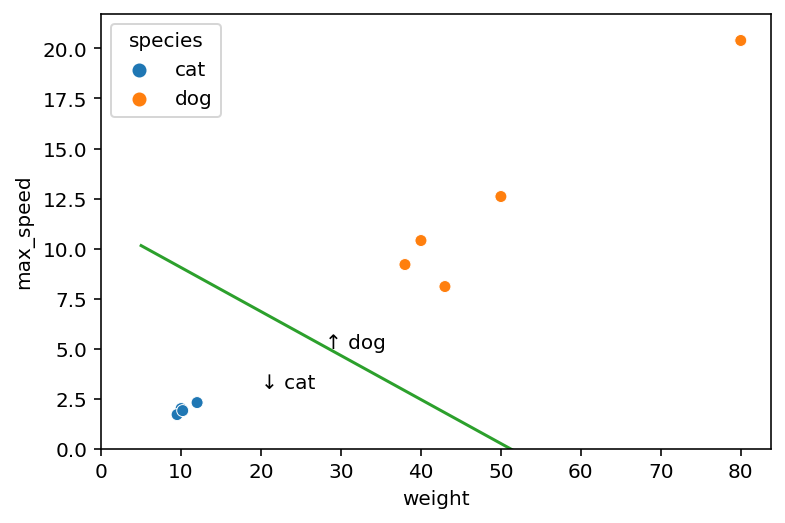

In [13]:
ax = sns.scatterplot(x="weight", y="max_speed", hue="species", data=df)

x = np.linspace(5, 80)
y = np.linspace(2.5, 20)
print(x.shape, y.shape)

c = est.coef_.flatten()
w = c[0]*x + c[1]*y + est.intercept_.item()
dividing_line = (-c[0]*x - est.intercept_) / c[1]
ax.plot(x, dividing_line, "C2", label="prediction")
ax.text(28, 5, "↑ dog")
ax.text(20, 3, "↓ cat")
ax.set_xlim(0, None)
ax.set_ylim(0, None)

**Takeaway**: choose the loss function based on your application!

Next: how can the model minimize the loss function?